In [1]:
# import libraries
import pandas as pd
import pygeos
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path
import os
import seaborn as sns
import datetime
import shapely
from shapely.geometry import shape, Point, LineString, Polygon
from collections import defaultdict

# set the working directory
BASE_DIR = Path.cwd()
print(BASE_DIR)

#set the project directory
project_folder = BASE_DIR.parent.parent
print(project_folder)

/tmp/pycharm_project_316/BEAM_Freight/Notebooks/GCE
/tmp/pycharm_project_316/BEAM_Freight


/home/goyal/.virtualenvs/venv_lbl_gce/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_89235/2396954251.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/lates

In [2]:
# Upload output in the respective bucket storage in the following path
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/*" or
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/plot/*" or

from google.cloud import storage
# Upload file to Google Cloud service
def upload_blob(_bucket_name, _source_file_name, _destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"
    storage_client = storage.Client()
    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_destination_blob_name)
    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to upload is aborted if the object's
    # generation number does not match your precondition. For a destination
    # object that does not yet exist, set the if_generation_match precondition to 0.
    # If the destination object already exists in your bucket, set instead a
    # generation-match precondition using its generation number.
    generation_match_precondition = 0
    blob.upload_from_filename(_source_file_name, if_generation_match=generation_match_precondition)
    print(
        f"File {_source_file_name} uploaded to {_destination_blob_name}."
    )

def delete_blob(_bucket_name, _blob_name):
    """Deletes a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # blob_name = "your-object-name"

    storage_client = storage.Client()

    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_blob_name)
    generation_match_precondition = None

    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to delete is aborted if the object's
    # generation number does not match your precondition.
    blob.reload()  # Fetch blob metadata to use in generation_match_precondition.
    generation_match_precondition = blob.generation

    blob.delete(if_generation_match=generation_match_precondition)

    print(f"Blob {_blob_name} deleted.")

In [3]:
# Basic Reference Points
city_name="austin"
gcloud_bucket = "gs://beam-core-outputs/output/austin"
iter_no = "0"
linkstats_file_path = f"{iter_no}.linkstats.csv.gz"
network_file_path = "network.csv.gz"
event_files_path = f"{iter_no}.events.csv.gz"
simulation_name = "austin-base-with-freight-2018__2023-04-14_16-11-13_yoq"
analysis_type = "Freight"
#Check if the folder exist, if not create it.
try:
    pathlib.Path(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot")).mkdir(parents=True, exist_ok=False)
except:
    pass

# load parameter and data for validation
meter_to_mile = 0.000621371
percent_of_samples = 0.5
mps_to_mph = 2.23694

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/BEAM_Network_NPMRDS_Screenline.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/BEAM_Network_NPMRDS_Screenline.png.


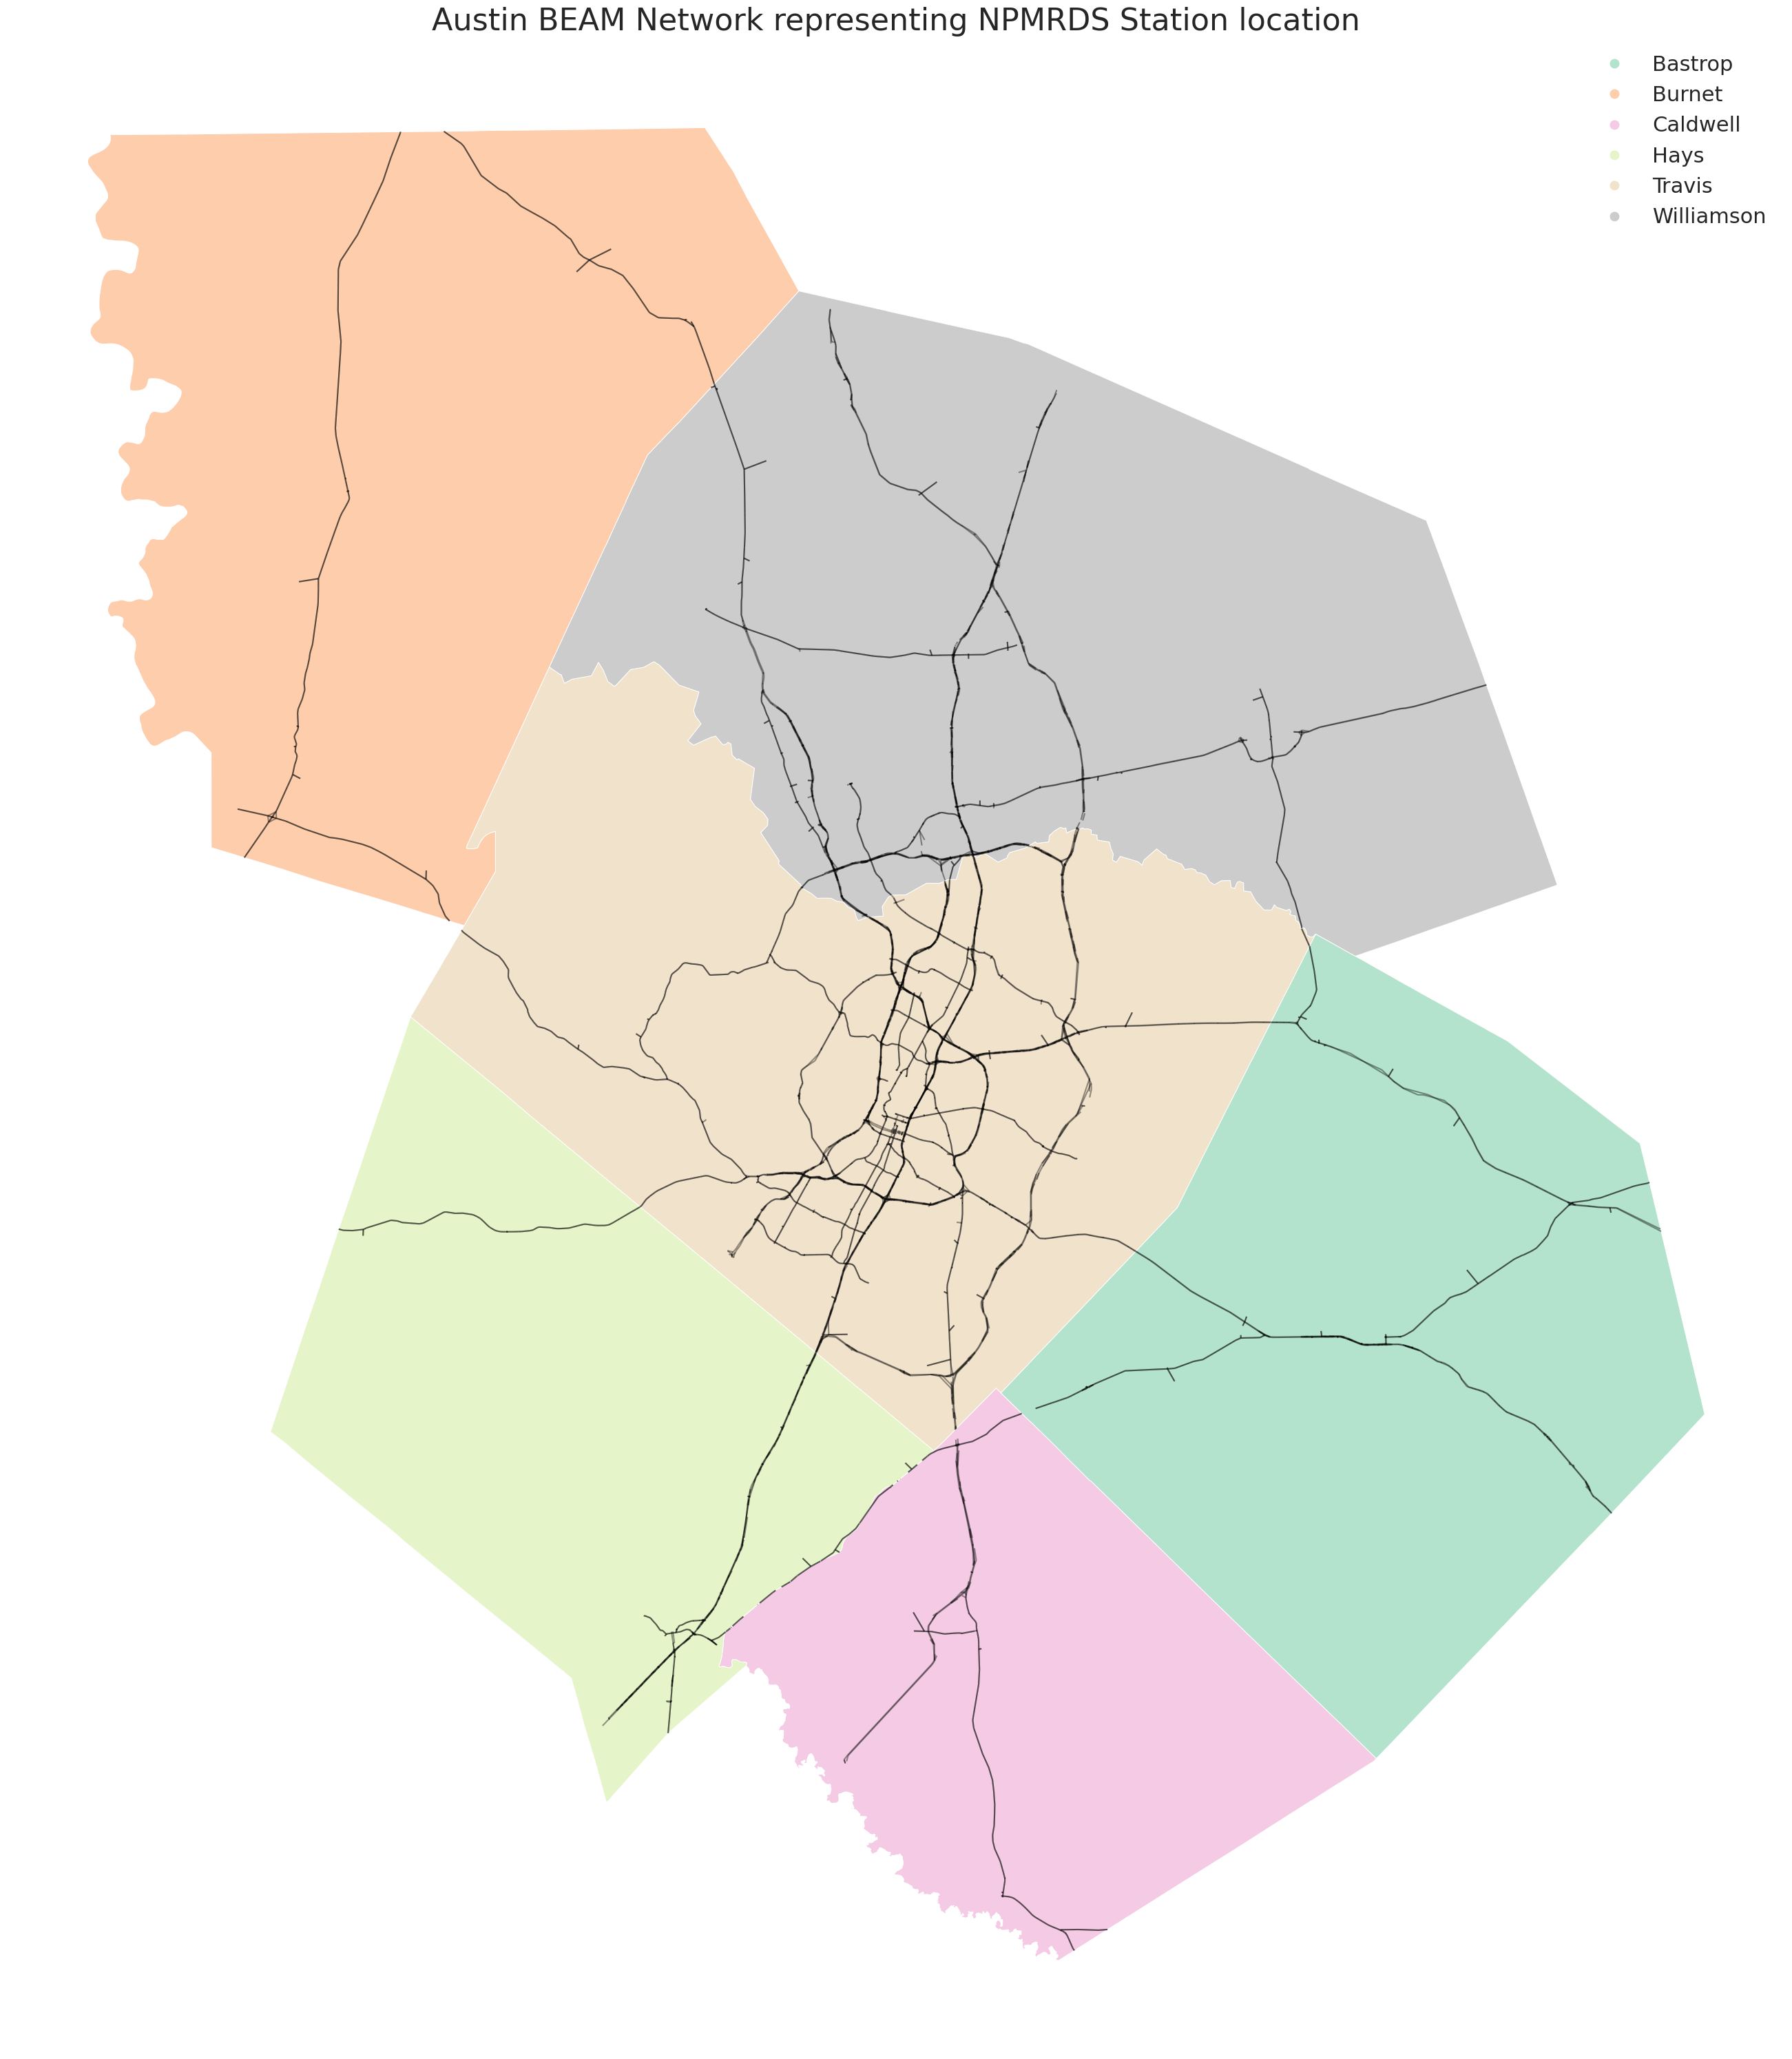

In [4]:
austin_npmrds_station = gpd.read_file(project_folder.joinpath("Reference_Data", city_name, "NPMRDS", "Austin_NPMRDS_Station.geojson"))
austin_npmrds_station = austin_npmrds_station.to_crs(3857)

austin_boundary = gpd.read_file(project_folder.joinpath("Reference_Data", city_name, "Austin_Counties.geojson"))
austin_boundary = austin_boundary.to_crs(3857)

beam_network = gpd.read_file(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "beam_network_by_county.geojson"))
beam_network = beam_network.to_crs(3857)

attributes_contains = ['motorway','motorway_link', 'trunk', 'trunk_link', 'primary','primary_link', 'secondary', 'secondary_link']
beam_network_with_cars = beam_network.loc[beam_network["attributeOrigType"].isin(attributes_contains)].copy()
beam_network_with_cars = beam_network_with_cars.loc[beam_network_with_cars["linkModes"].isin(['car;bike', 'car;walk;bike'])].copy()

# intersect beam_network_with_cars with austin_npmrds_station, and keep only those links which has distance<50meter
selected_beam_network_out = gpd.sjoin_nearest(beam_network_with_cars, austin_npmrds_station, distance_col="distance_to_npmrds_stn", max_distance=50)
# for given linkId, if it is close to more than one NPMRDS station  one, the sort the dataframe and *only* keep the first available result
selected_beam_network_filtered = selected_beam_network_out.sort_values(["linkId","Tmc", "distance_to_npmrds_stn"],ascending=[True, True, True]).drop_duplicates(subset="linkId", keep="first").copy()

fig, ax=plt.subplots(figsize=(30,30))
austin_boundary.plot(ax=ax,lw=0.7,column='name', categorical=True, cmap='Pastel2',legend=True, legend_kwds={'fontsize':22,'frameon':False})
selected_beam_network_filtered.to_crs(3857, inplace=True)
selected_beam_network_filtered.plot(ax=ax,edgecolor='black',alpha= 0.4,)

ax.axis('off')
ax.set_title(f'{city_name.title()} BEAM Network representing NPMRDS Station location',fontsize=32)
plt.tight_layout()
plt_file_name=f"BEAM_Network_NPMRDS_Screenline.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi=600)

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [5]:
gpd_fc_file_name = "BEAM_Network_NPMRDS_Screenline.geojson"
selected_beam_network_filtered.to_file(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, gpd_fc_file_name), driver="GeoJSON")

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, gpd_fc_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/{gpd_fc_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/BEAM_Network_NPMRDS_Screenline.geojson uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/BEAM_Network_NPMRDS_Screenline.geojson.


In [6]:
df_file_name = "BEAM_Network_NPMRDS_Screenline.csv"
selected_beam_network_filtered.loc[:, ~selected_beam_network_filtered.columns.isin(["geometry"])].to_csv(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, df_file_name))
bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, df_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/{df_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/BEAM_Network_NPMRDS_Screenline.csv uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/BEAM_Network_NPMRDS_Screenline.csv.


File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/Austin_NPMRDS_Screenline.geojson uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/Austin_NPMRDS_Screenline.geojson.


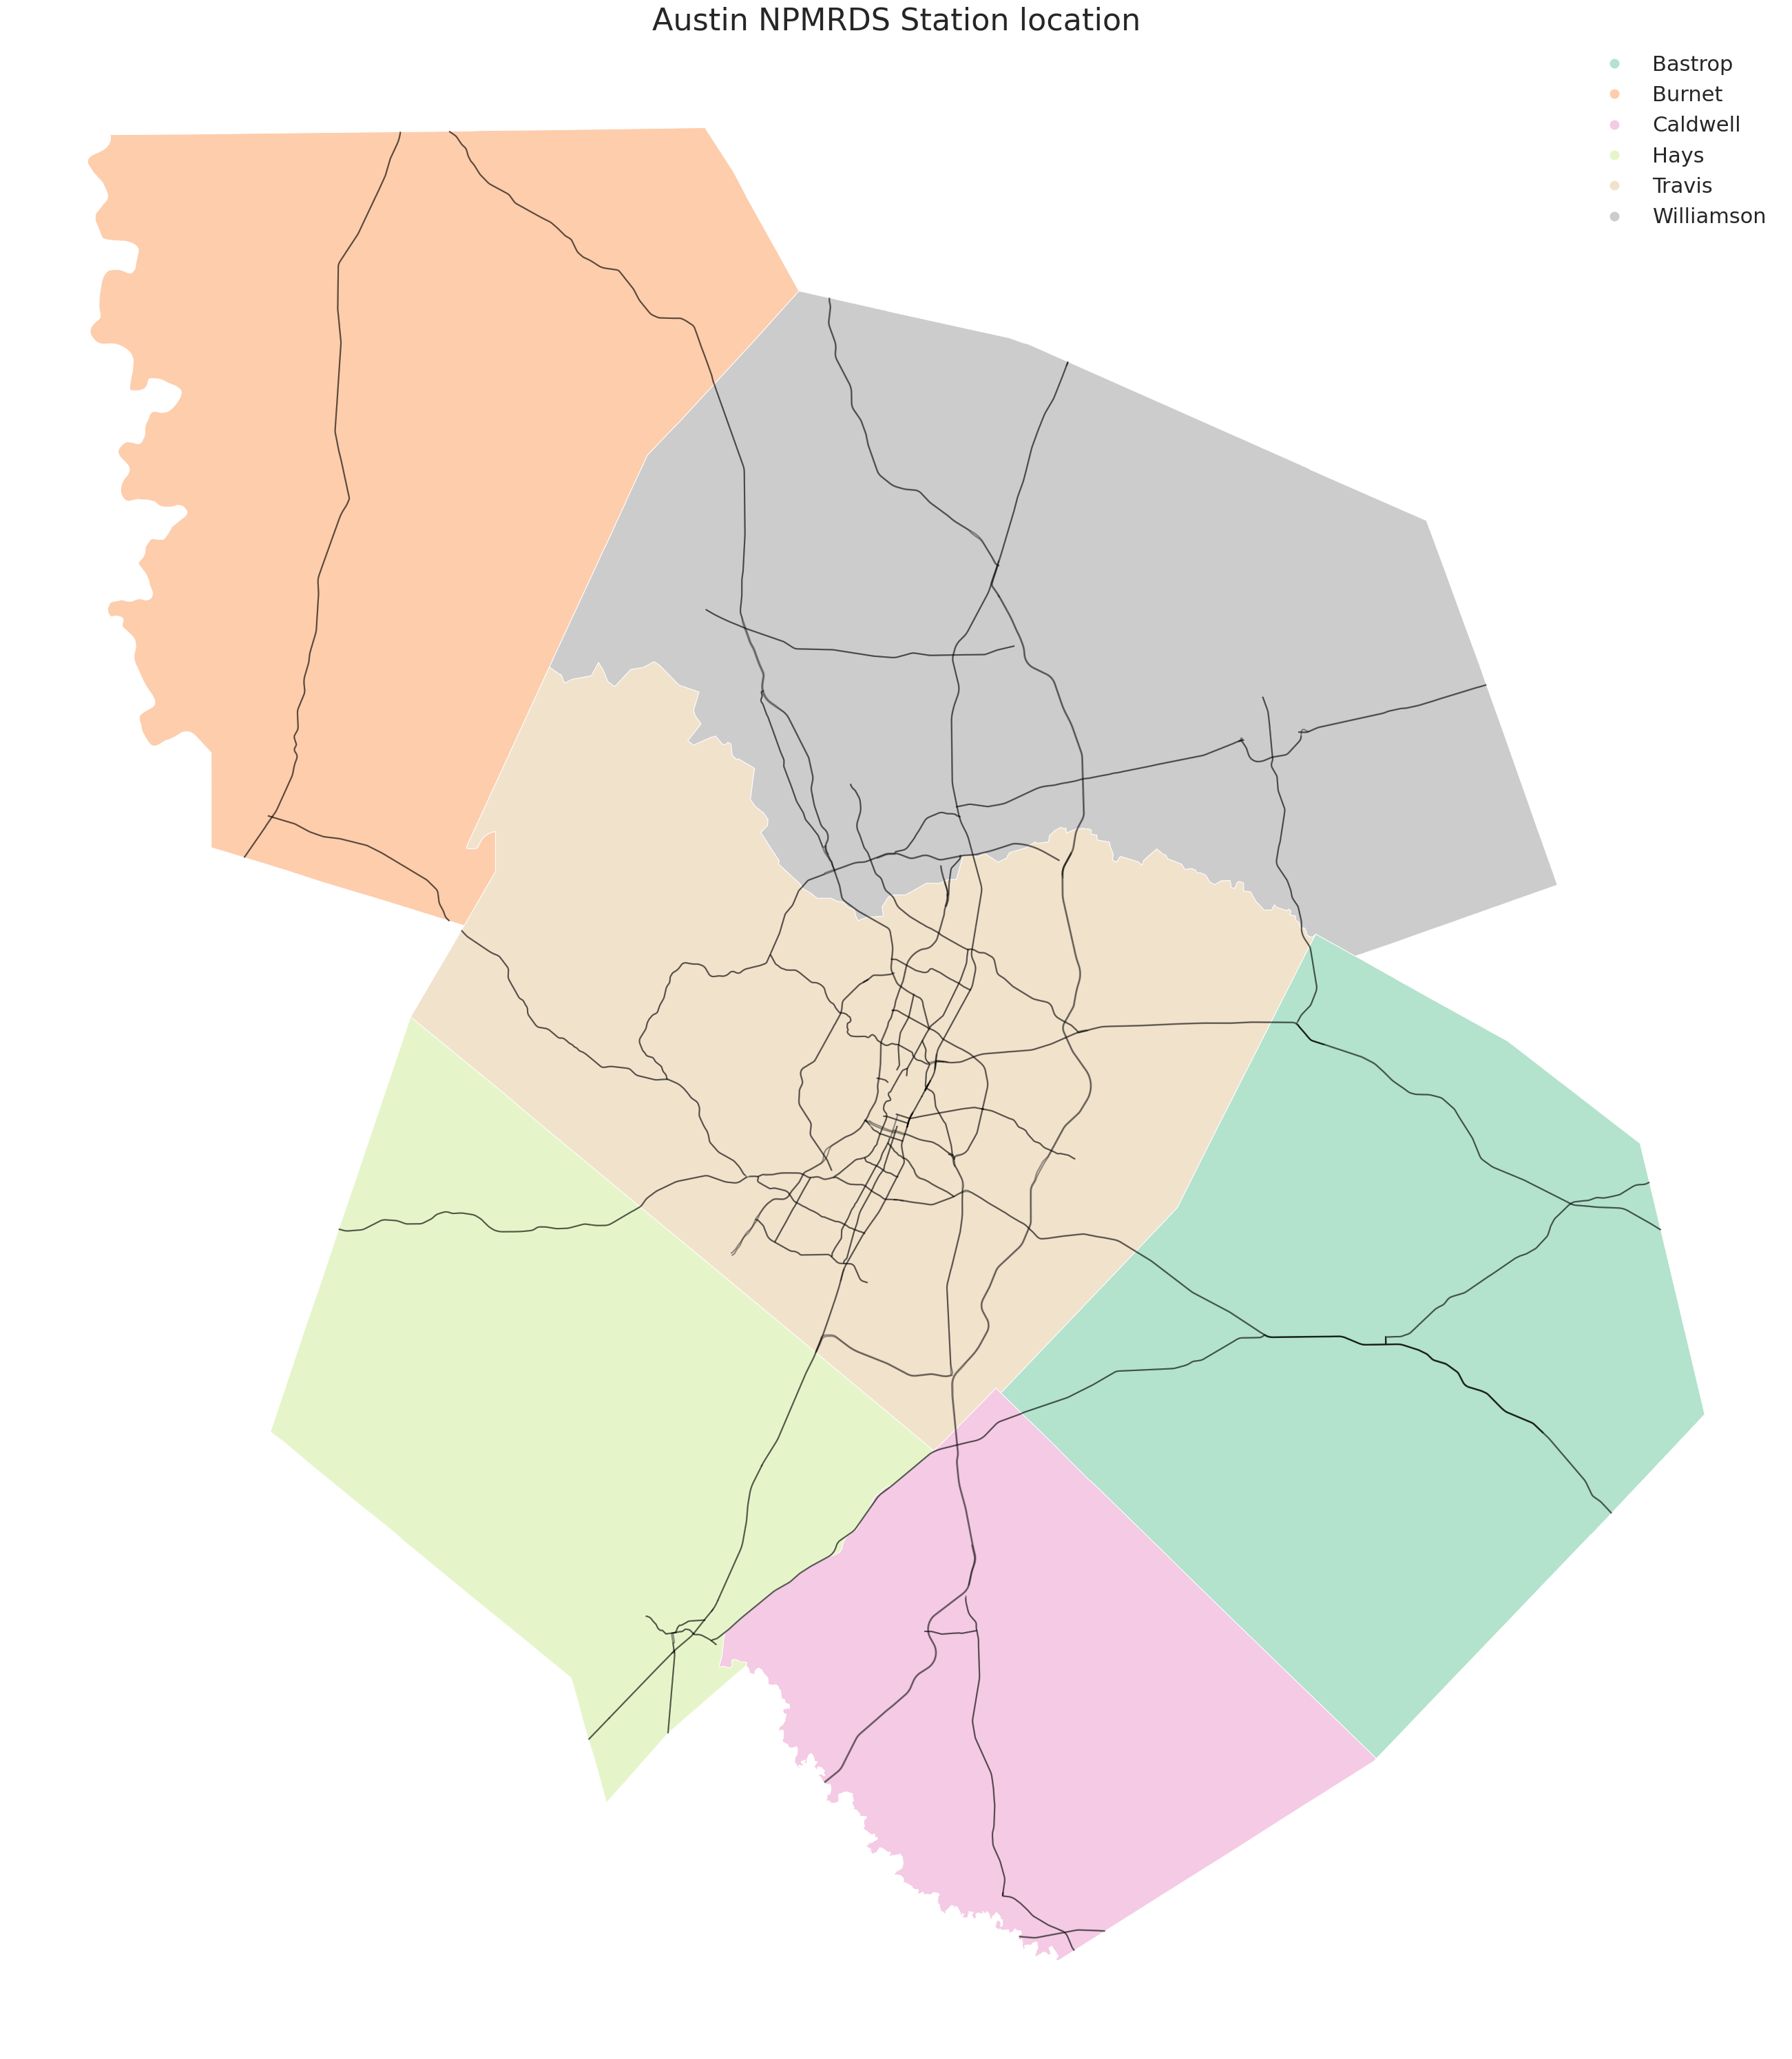

In [7]:
fig, ax=plt.subplots(figsize=(30,30))
austin_boundary.plot(ax=ax,lw=0.7,column='name', categorical=True, cmap='Pastel2',legend=True, legend_kwds={'fontsize':22,'frameon':False})
austin_npmrds_station.to_crs(3857, inplace=True)
austin_npmrds_station.plot(ax=ax,edgecolor='black',alpha= 0.4,)

ax.axis('off')
ax.set_title(f'{city_name.title()} NPMRDS Station location',fontsize=32)
plt.tight_layout()
plt_file_name=f"{city_name.title()}_NPMRDS_Screenline.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi=600)

gpd_fc_file_name = f"{city_name.title()}_NPMRDS_Screenline.geojson"
austin_npmrds_station.to_file(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, gpd_fc_file_name), driver="GeoJSON")
bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, gpd_fc_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/{gpd_fc_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [36]:
# selected_beam_network_out = gpd.sjoin_nearest(beam_network_with_cars, austin_npmrds_station, distance_col="distance_to_npmrds_stn", max_distance=50)
# selected_beam_network_filtered = selected_beam_network_out.sort_values(["linkId","Tmc", "distance_to_npmrds_stn"],ascending=[True, True, True]).drop_duplicates(subset="linkId", keep="first").copy()
# df.groupby('linkId', group_keys=False).apply(lambda x: x.loc[x.distance_to_npmrds_stn.idxmin()])
# selected_beam_network_filtered